In [1]:
import sys
sys.path.insert(0, '../pyLDLE2/')

In [2]:
import numpy as np
from pyLDLE2 import util_, visualize_, datasets
from scipy.sparse import coo_matrix
from scipy import optimize
from scipy.special import erf
from matplotlib import pyplot as plt
from scipy.stats import chi2

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [3]:
vis = visualize_.Visualize()

In [4]:
# X, labelsMat, ddX = datasets.Datasets().circular_disk(RES=50)
X, labelsMat, ddX = datasets.Datasets().circular_disk_sauer(n=12500)

X.shape =  (7430, 2)


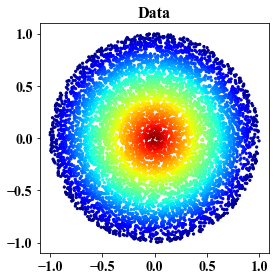

In [5]:
vis.data(X, ddX)

In [90]:
k_nn = 2048 # 128
neigh_dist, neigh_ind = util_.nearest_neighbors(X, k_nn, metric='euclidean')

In [110]:
h_cand = np.sqrt(2)*neigh_dist[:,-1]/np.sqrt(chi2.ppf(0.99, df=2))
print(np.min(h_cand), np.median(h_cand), np.max(h_cand))
#h = np.min(h_cand)
h = 0.1
K = np.exp(-neigh_dist**2/h**2)

0.21640892426660258 0.26685065603432556 0.3924738187557364


In [111]:
n = X.shape[0]
source_ind = np.repeat(np.arange(n),neigh_ind.shape[1])
K = coo_matrix((K.flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))
ones_K_like = coo_matrix((np.ones(neigh_dist.shape).flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))

# symmetrize
K = K + K.T
ones_K_like = ones_K_like + ones_K_like.T
K.data /= ones_K_like.data

In [112]:
mu_hN_norm = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    temp = X-X[i,:][None,:]
    mu_hN_norm[i] = np.linalg.norm(K.getrow(i).dot(temp))

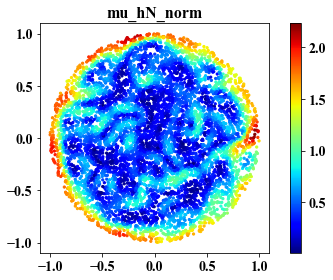

In [113]:
vis.data(X, mu_hN_norm, title='mu_hN_norm', colorbar=True)

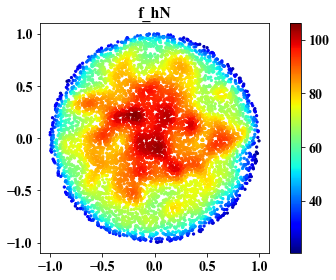

In [114]:
vis.data(X, np.array(K.sum(axis=1)).flatten(), title='f_hN', colorbar=True)

In [115]:
c_num = h*np.array(K.sum(axis=1)).flatten()/np.sqrt(np.pi)
c_denom = mu_hN_norm
c = c_num/(c_denom+1e-20)

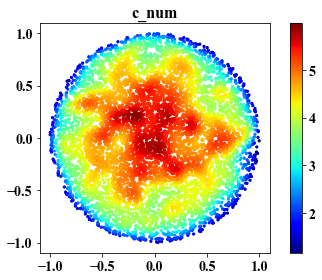

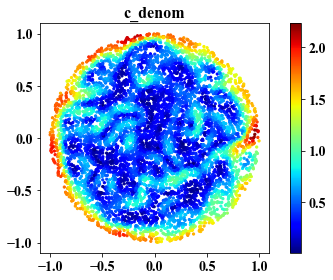

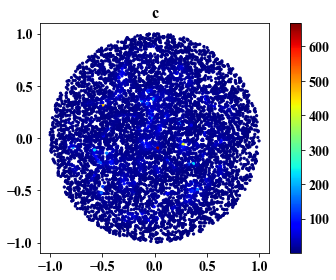

In [116]:
vis.data(X, c_num, title='c_num', colorbar=True)
vis.data(X, c_denom, title='c_denom', colorbar=True)
vis.data(X, c, title='c', colorbar=True)

In [117]:
def F(x):
    return c_denom*(1+erf(x/h))*np.exp(x**2/h**2)-c_num

def F_prime(x):
    return (c_denom/h)*(2/np.sqrt(np.pi) + 2*(1+erf(x/h))*np.exp(x**2/h**2)*x/h)

In [118]:
bx_init = h*np.sqrt(np.maximum(0, -np.log(2*c_denom+1e-30)+np.log(c_num+1e-30)))

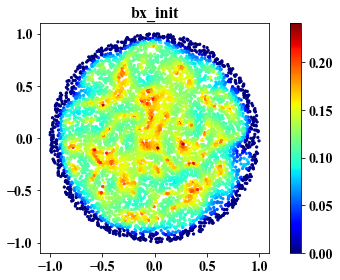

In [119]:
vis.data(X, bx_init, title='bx_init', colorbar=True)

In [120]:
bx = optimize.newton(F, bx_init, F_prime, maxiter=50)
bx = np.maximum(bx, 0)

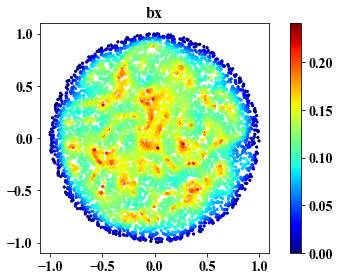

In [121]:
vis.data(X, bx, title='bx', colorbar=True)

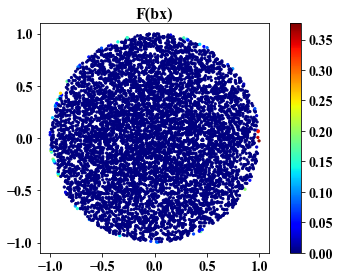

In [122]:
vis.data(X, np.abs(F(bx)), title='F(bx)', colorbar=True)

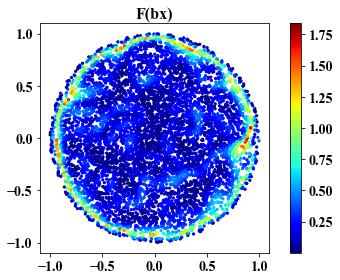

In [123]:
vis.data(X, np.abs(F(bx_init)), title='F(bx)', colorbar=True)

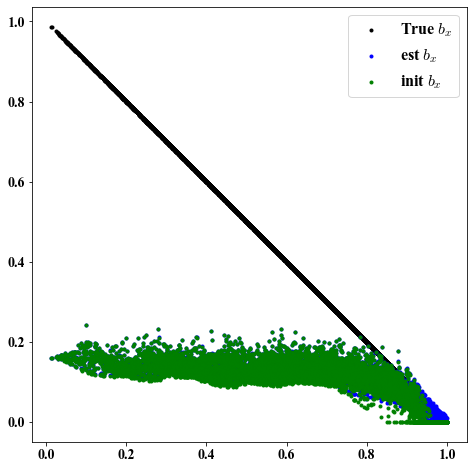

In [124]:
plt.figure(figsize=(8,8))
plt.scatter(np.linalg.norm(X[:,:2], axis=1), ddX, color='k', label='True $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx, color='b', label='est $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx_init, color='g', label='init $b_x$')
plt.axis('image')
plt.legend()

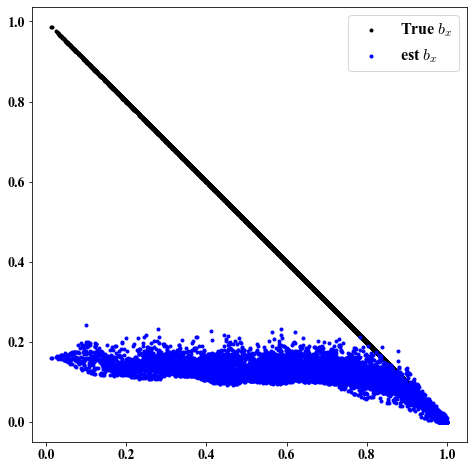

In [125]:
plt.figure(figsize=(8,8))
plt.scatter(np.linalg.norm(X[:,:2], axis=1), ddX, color='k', label='True $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx, color='b', label='est $b_x$')
plt.axis('image')
plt.legend()

In [126]:
m0_1 = 0.5*(1+erf(bx/h))
#m0_1 = 0.5*(1+erf(ddX/h))

In [127]:
q3 =  (np.pi**(-2/2))*np.array(K.sum(axis=1)).flatten()/((n-1)*h**2)
q4 =  (np.pi**(-2/2))*np.array(K.sum(axis=1)).flatten()/(m0_1*((n-1)*h**2))

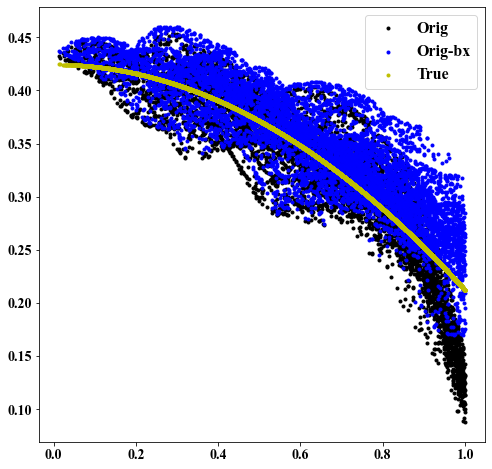

In [128]:
plt.figure(figsize=(8,8))
plt.scatter(np.linalg.norm(X[:,:2], axis=1), q3, color='k', label='Orig')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), q4, color='b', label='Orig-bx')
r = np.linalg.norm(X[:,:2], axis=1)
plt.scatter(r, (2/(3*np.pi))*(2-r**2), color='y', label='True')
plt.legend()